In [ ]:
!pip install diffusers transformers accelerate scipy safetensors
!pip install carvekit

In [ ]:
import json
from typing import List
import requests as r
import base64
from io import BytesIO
import json

from PIL import Image

from carvekit.api.interface import Interface
from carvekit.ml.wrap.fba_matting import FBAMatting
from carvekit.ml.wrap.tracer_b7 import TracerUniversalB7
from carvekit.pipelines.postprocessing import MattingMethod
from carvekit.pipelines.preprocessing import PreprocessingStub
from carvekit.trimap.generator import TrimapGenerator

import cv2
import numpy as np

import requests
from diffusers.utils import make_image_grid, load_image

from diffusers import StableDiffusionInpaintPipeline
import torch

import matplotlib.pyplot as plt

In [ ]:
# Carvekit initialization
seg_net = TracerUniversalB7(device="cpu", batch_size=1)

fba = FBAMatting(device="cpu", input_tensor_size=2048, batch_size=1)

trimap = TrimapGenerator()

preprocessing = PreprocessingStub()

postprocessing = MattingMethod(
    matting_module=fba, trimap_generator=trimap, device="cpu"
)

carvekit_processor = Interface(
    pre_pipe=preprocessing, post_pipe=postprocessing, seg_pipe=seg_net
)

In [ ]:
# Stable diffusion initialization
model_id = "stabilityai/stable-diffusion-2-1"
# model_id = "runwayml/stable-diffusion-inpainting"
pipe = StableDiffusionInpaintPipeline.from_pretrained(
    model_id,
    revision="fp16",
    torch_dtype=torch.float16,
)
pipe = pipe.to("cuda")

unet/diffusion_pytorch_model.safetensors not found


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [ ]:
def carvekit_processing(input_image):
    try:
        rmbg_image = carvekit_processor([input_image])[0]
        return rmbg_image
    except:
        return False

In [ ]:
# # Get mask of image
# def get_mask(input_image):
#   rmbg_image = carvekit_processing(input_image)
#   bg = np.array(rmbg_image)
#   mask_image = Image.fromarray(cv2.bitwise_not(bg[:, :, 3]))
#   return mask_image

In [ ]:
def get_mask(input_image):
  """
  return: bg_remove_res_rgb: Ảnh gốc đã xóa background
  mask_image: ảnh mask
  """
  rmbg_image = carvekit_processing(input_image)
  bg = np.array(rmbg_image)
  mask_image = Image.fromarray(cv2.bitwise_not(bg[:, :, 3]))

  bg_remove_res_rgb = cv2.cvtColor(np.array(bg), cv2.COLOR_RGBA2RGB)
  bg_remove_res_rgb = Image.fromarray(bg_remove_res_rgb)
  return bg_remove_res_rgb, mask_image

In [ ]:
def encode_image(image):
    return base64.b64encode(image.tobytes()).decode("utf-8")

In [ ]:
# Predict
def predict(prompt, negative_prompt, bg_remove_res_rgb, mask_image):

  # LOCAL
  # final_images = pipe(prompt=prompt, image=input_image, mask_image=mask_image, num_images_per_prompt=4).images
  final_images = pipe(prompt=prompt, image=bg_remove_res_rgb, mask_image=mask_image.resize(bg_remove_res_rgb.size), \
                               num_images_per_prompt=4, num_inference_steps = 50, guidance_scale = 7.5).images

  # HOSTING
  # encoded_rmbg_image = encode_image(rmbg_image)
  # encoded_mask_image = encode_image(mask_image)

  # prepare sample payload
  # request = {
  #     "inputs": prompt,
  #     "image": encoded_rmbg_image,
  #     "mask_image": encoded_mask_image,
  # }
  # # headers
  # headers = {
  #     "Authorization": f"Bearer {HF_TOKEN}",
  #     "Content-Type": "application/json",
  #     "Accept": "application/json",
  # }

  # response = requests.post(ENDPOINT_URL, headers=headers, json=request)

  # Post-processing response
  json_imgs = {}
  for i in range(len(final_images)):
    buffered = BytesIO()
    final_images[i].save(buffered, format="PNG")
    img_str = base64.b64encode(buffered.getvalue())
    json_imgs[f"{i}"] = img_str

  return json_imgs

In [ ]:
def receive_image(token, prompt, negative_prompt, input_image_path):
  # # Validate token
  # if not await validate_token(token):
  #     return return_response_handler()

  # # print(token)

  # # Validate input image
  # if img_file.content_type.split("/")[0] != "image":
  #     return return_response_handler()

  input_image = load_image(input_image_path)

  # # Save rmbg_image (DEBUG)
  # rmbg_image_path = input_image_path.rsplit(".", 1)[0] + "_rmbg" + ".png"
  # rmbg_image.save(rmbg_image_path)

  bg_remove_res_rgb, mask_image = get_mask(input_image)
  # # Save image mask (DEBUG)
  # image_mask_path = input_image_path.rsplit(".", 1)[0] + "_mask" + ".png"
  # mask_image.save(image_mask_path)

  new_background_images = predict(prompt=prompt, negative_prompt=negative_prompt, bg_remove_res_rgb=bg_remove_res_rgb, mask_image=mask_image)

  return new_background_images

In [ ]:
prompt = "on a fur luxury!, no pattern fur carpet background, bird's-eye view perpendicular shot, unreal engine, high resolution, ultra realistic, hyperreailistic, 8k, sharp focus, pixabay, extremely detailed"
negative_prompt = "low resolution, low details, blurry, add detail around, add pattern for carpet"
# negative_prompt = "make the shampoo bottle rectangular"

# url = "https://zacshop.com/cdn/shop/articles/bottle-perfume-with-word-perfume-it.jpg?v=1687911687"
url = "https://images.pexels.com/photos/1557980/pexels-photo-1557980.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=1"

input_image_path = "perfume.jpg"
response = Image.open(requests.get(url, stream=True).raw)
response.save(input_image_path)

final_images = receive_image(token="", prompt=prompt, negative_prompt=negative_prompt, input_image_path=input_image_path)

  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
# final_images["0"]

In [ ]:
def print_image(img_str):
  base64_image = base64.b64decode(img_str)
  buffer = BytesIO(base64_image)
  image = Image.open(buffer)
  return image

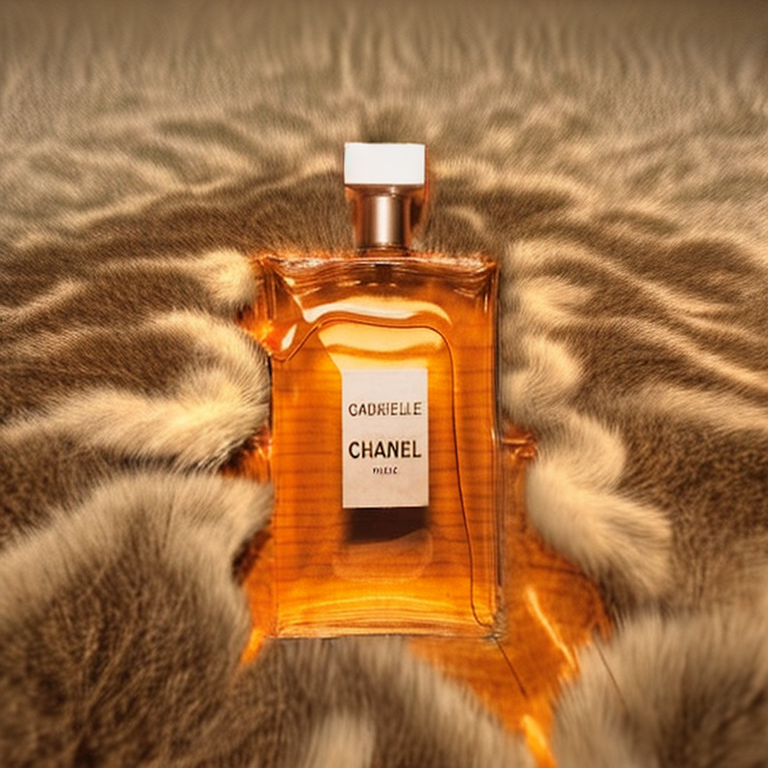

In [ ]:
print_image(final_images["0"])

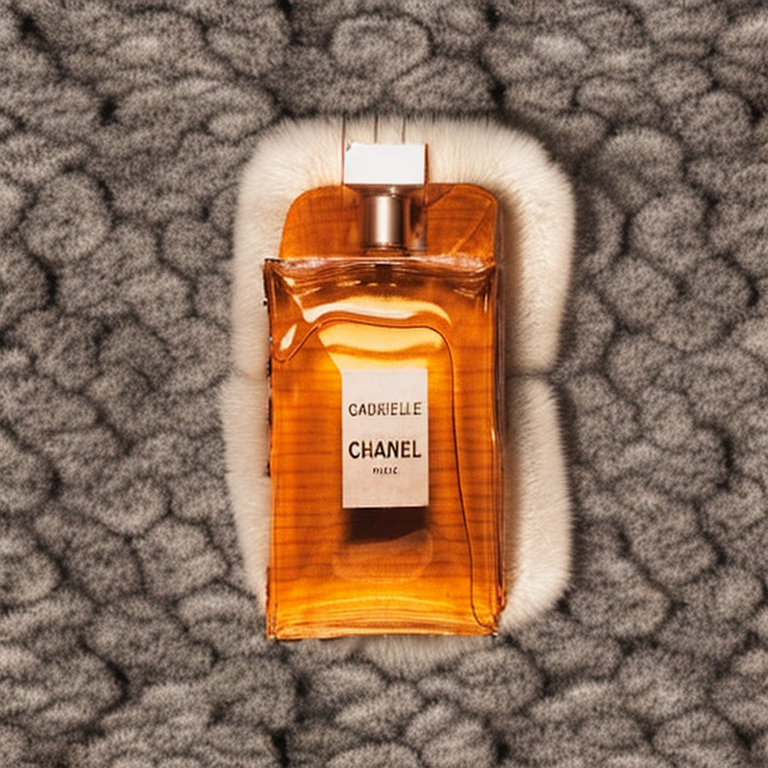

In [ ]:
print_image(final_images["1"])

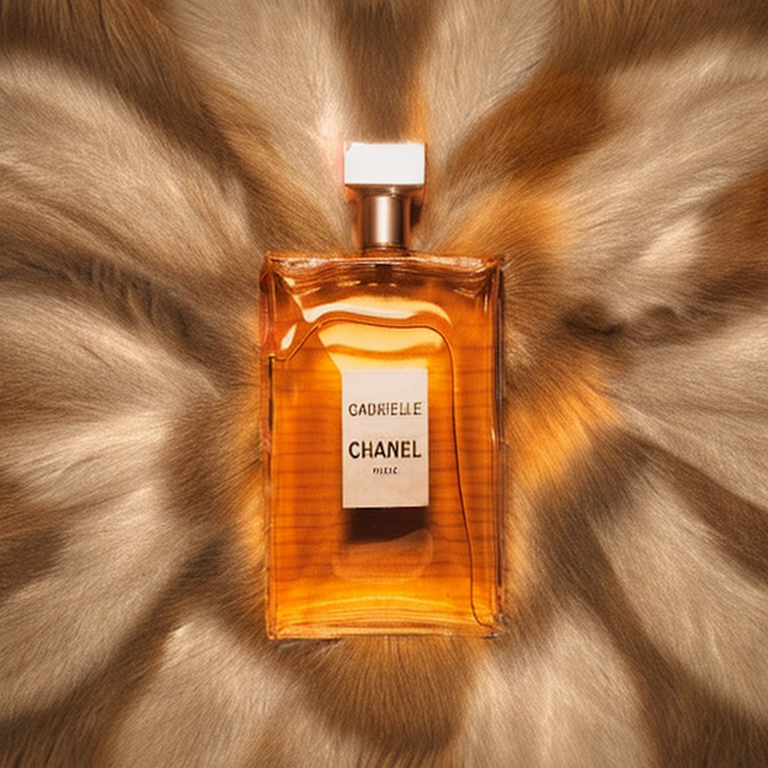

In [ ]:
print_image(final_images["2"])

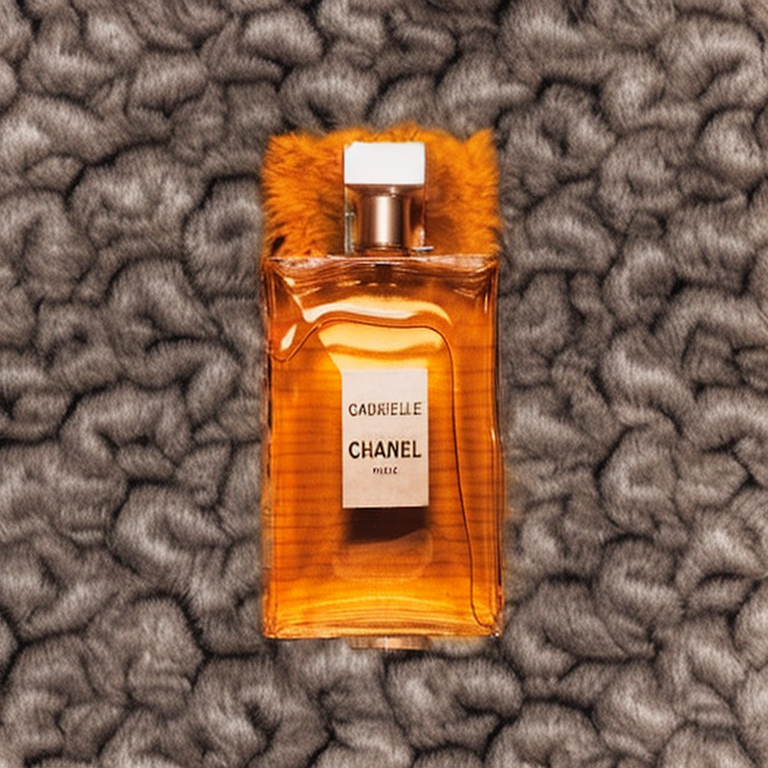

In [ ]:
print_image(final_images["3"])